# Arkham Word Clouds
Created: 2021-09-02  
Updated: 2021-11-21  
Author: Spencer Simon

This notebook loads data from [arkhamdb.com](https://arkhamdb.com) using their [public api](https://arkhamdb.com/api/). Then, I created wordclouds and other visualizations of the data.

## Setup
Install and Import Libraries

In [1]:
#!pip install textblob
#!pip install cufflinks
#!pip install scattertext
#!pip install spacy
#!pip install chart_studio
#!pip install bokeh

#import nltk
#nltk.download('punkt')
#!python -m textblob.download_corpora
#!python3 -m spacy download en_core_web_sm

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import urllib.request, json 
import re
#import requests
#import os
from requests.auth import HTTPBasicAuth
from bs4 import BeautifulSoup
from pathlib import Path

In [3]:
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
import cufflinks
#pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import chart_studio.plotly as py
import plotly.graph_objects as go

Loading BokehJS ...

In [5]:
plt.style.use('bmh')
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

In [6]:
pd.set_option("display.max_columns", None)

In [45]:
from wordcloud import ImageColorGenerator

## Query arkhamdb to get data

In [7]:
base_url = 'https://arkhamdb.com'
api_all_cards = '/api/public/cards/'

In [8]:
url_all_cards = base_url + api_all_cards

In [9]:
with urllib.request.urlopen(url_all_cards) as url:
    data = json.loads(url.read().decode())
    print(json.dumps(data, indent=1))

[
 {
  "pack_code": "core",
  "pack_name": "Core Set",
  "type_code": "treachery",
  "type_name": "Treachery",
  "subtype_code": "basicweakness",
  "subtype_name": "Basic Weakness",
  "faction_code": "neutral",
  "faction_name": "Neutral",
  "position": 1000,
  "exceptional": false,
  "myriad": false,
  "code": "01000",
  "name": "Random Basic Weakness",
  "real_name": "Random Basic Weakness",
  "text": "This is a placeholder random basic weakness\n You can replace it with a specific weakness using the Special tab or click the random button to replace it with a random weakness from your collection.",
  "real_text": "This is a placeholder random basic weakness\n You can replace it with a specific weakness using the Special tab or click the random button to replace it with a random weakness from your collection.",
  "quantity": 1,
  "health_per_investigator": false,
  "deck_limit": 1,
  "real_slot": "",
  "traits": "",
  "real_traits": "",
  "is_unique": false,
  "hidden": true,
  "perma

In [10]:
df_cards = pd.read_json(url_all_cards)

In [11]:
df_cards.sample(10)

,pack_code,pack_name,type_code,type_name,subtype_code,subtype_name,faction_code,faction_name,position,exceptional,myriad,code,name,real_name,text,real_text,quantity,health_per_investigator,deck_limit,real_slot,traits,real_traits,is_unique,hidden,permanent,double_sided,url,subname,skill_willpower,skill_intellect,skill_combat,skill_agility,health,sanity,deck_requirements,deck_options,flavor,illustrator,back_text,back_flavor,octgn_id,imagesrc,backimagesrc,cost,skill_wild,slot,restrictions,xp,duplicated_by,enemy_damage,enemy_horror,enemy_fight,enemy_evade,victory,exile,linked_to_code,linked_to_name,linked_card,faction2_code,faction2_name,bonded_cards,bonded_to,bonded_count,shroud,clues,faction3_code,faction3_name,duplicate_of_code,duplicate_of_name,alternate_of_code,alternate_of_name
976,rtptc,Return to the Path to Carcosa,asset,Asset,NaN,NaN,rogue,Rogue,6,False,False,52006,Suggestion,Suggestion,Uses (3 charges). If Suggestion has no charges...,Uses (3 charges). If Suggestion has no charges...,2,False,2.0,Arcane,Spell.,Spell.,False,NaN,False,False,https://arkhamdb.com/card/52006,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Owen William Weber,NaN,NaN,a830a18b-0c79-4f02-b3de-c2bd2f1083ef,/bundles/cards/52006.jpg,NaN,3.0,NaN,Arcane,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1151,ste,Stella Clark,asset,Asset,NaN,NaN,survivor,Survivor,9,False,False,60509,Mysterious Raven,Mysterious Raven,[fast] Discard Mysterious Raven and take 1 hor...,[fast] Discard Mysterious Raven and take 1 hor...,2,False,2.0,Ally,Ally. Creature.,Ally. Creature.,False,NaN,False,False,https://arkhamdb.com/card/60509,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,"""And his eyes have all the seeming\nof a demon...",Stanislav Dikolenko,NaN,NaN,bd1af7e0-2193-4335-a29d-5c8cef7fa08b,/bundles/cards/60509.jpg,NaN,1.0,NaN,Ally,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
647,dsm,Dark Side of the Moon,asset,Asset,NaN,NaN,guardian,Guardian,195,False,False,06195,.35 Winchester,.35 Winchester,Uses (5 ammo).\n[action]: <b>Fight.</b> You ge...,Uses (5 ammo).\n[action]: <b>Fight.</b> You ge...,2,False,2.0,Hand x2,Item. Weapon. Firearm.,Item. Weapon. Firearm.,False,NaN,False,False,https://arkhamdb.com/card/06195,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Stephen Somers,NaN,NaN,56924231-f626-4110-a6cb-110051423225,/bundles/cards/06195.jpg,NaN,4.0,NaN,Hand x2,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,dwl,The Dunwich Legacy,asset,Asset,NaN,NaN,seeker,Seeker,21,False,False,02021,Strange Solution,Strange Solution,"[action] Test [intellect] (4). If you succeed,...","[action] Test [intellect] (4). If you succeed,...",2,False,2.0,,Item. Science.,Item. Science.,False,NaN,False,False,https://arkhamdb.com/card/02021,Unidentified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"By all accounts, it should not even exist.",Tiziano Baracchi,NaN,NaN,76d32cbe-c709-4ae3-94ba-041312b958c9,/bundles/cards/02021.png,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1144,ste,Stella Clark,skill,Skill,NaN,NaN,survivor,Survivor,2,False,False,60502,Neither Rain nor Snow,Neither Rain nor Snow,Stella Clark deck only.\nIf this skill test fa...,Stella Clark deck only.\nIf this skill test fa...,3,False,3.0,,Innate. Developed.,Innate. Developed.,False,NaN,False,False,https://arkhamdb.com/card/60502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...nor gloom of night stays these couriers fro...,Aleksander Karcz,NaN,NaN,6f5ec3f2-a33c-46f4-b783-740889255748,/bundles/cards/60502.jpg,NaN,NaN,3.0,NaN,{'investigator': {'60501': '60501'}},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,wgd,Where the Gods Dwell,event,Event,NaN,NaN,survivor,Survivor,284,False,False,06284,Nothing Left to Lose,Nothing Left to Lose,"If you have fewer than 5 resources, gain resou...","If you have fewer

## Process data & text

### Check Null Values

In [12]:
df_cards.isnull().sum()

pack_code               0
pack_name               0
type_code               0
type_name               0
subtype_code         1116
                     ... 
faction3_name        1223
duplicate_of_code    1205
duplicate_of_name    1205
alternate_of_code    1224
alternate_of_name    1224
Length: 71, dtype: int64

From above, we can see that many columns have null values. However, important columns such as name, text, and code have 0 NULLs.

In [13]:
# Create new df for text analysis
df_card_text = df_cards.copy()
df_card_text.sample(10)

,pack_code,pack_name,type_code,type_name,subtype_code,subtype_name,faction_code,faction_name,position,exceptional,myriad,code,name,real_name,text,real_text,quantity,health_per_investigator,deck_limit,real_slot,traits,real_traits,is_unique,hidden,permanent,double_sided,url,subname,skill_willpower,skill_intellect,skill_combat,skill_agility,health,sanity,deck_requirements,deck_options,flavor,illustrator,back_text,back_flavor,octgn_id,imagesrc,backimagesrc,cost,skill_wild,slot,restrictions,xp,duplicated_by,enemy_damage,enemy_horror,enemy_fight,enemy_evade,victory,exile,linked_to_code,linked_to_name,linked_card,faction2_code,faction2_name,bonded_cards,bonded_to,bonded_count,shroud,clues,faction3_code,faction3_name,duplicate_of_code,duplicate_of_name,alternate_of_code,alternate_of_name
124,dwl,The Dunwich Legacy,asset,Asset,NaN,NaN,seeker,Seeker,21,False,False,02021,Strange Solution,Strange Solution,"[action] Test [intellect] (4). If you succeed,...","[action] Test [intellect] (4). If you succeed,...",2,False,2.0,,Item. Science.,Item. Science.,False,NaN,False,False,https://arkhamdb.com/card/02021,Unidentified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"By all accounts, it should not even exist.",Tiziano Baracchi,NaN,NaN,76d32cbe-c709-4ae3-94ba-041312b958c9,/bundles/cards/02021.png,NaN,1.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,ptc,The Path to Carcosa,asset,Asset,NaN,NaN,seeker,Seeker,25,False,False,03025,Archaic Glyphs,Archaic Glyphs,[action] Discard a card with at least 1 [intel...,[action] Discard a card with at least 1 [intel...,2,False,2.0,Hand,Item. Occult. Tome.,Item. Occult. Tome.,False,NaN,False,False,https://arkhamdb.com/card/03025,Untranslated,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anna Christenson,NaN,NaN,38b19e4f-1a9e-4581-a8ac-2284d61c43a1,/bundles/cards/03025.png,NaN,0.0,NaN,Hand,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,pnr,Point of No Return,asset,Asset,NaN,NaN,mystic,Mystic,242,False,True,06242,Empower Self,Empower Self,Myriad. Limit 1 Empower Self <i>(Alacrity)</i>...,Myriad. Limit 1 Empower Self <i>(Alacrity)</i>...,1,False,1.0,Arcane,Ritual.,Ritual.,False,NaN,False,False,https://arkhamdb.com/card/06242,Alacrity,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,Felipe Escobar,NaN,NaN,a22af06f-e75c-45e1-a5aa-32dd6ccdd70c,/bundles/cards/06242.jpg,NaN,3.0,NaN,Arcane,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,ptc,The Path to Carcosa,treachery,Treachery,weakness,Weakness,neutral,Neutral,13,False,False,03013,Stars of Hyades,Stars of Hyades,<b>Revelation</b> - Randomly choose an event b...,<b>Revelation</b> - Randomly choose an event b...,1,False,1.0,,Curse.,Curse.,False,NaN,False,False,https://arkhamdb.com/card/03013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ethan Patrick Harris,NaN,NaN,0edbea65-8d12-43dc-ad58-56fd907d12a8,/bundles/cards/03013.png,NaN,NaN,NaN,NaN,{'investigator': {'03003': '03003'}},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,tde,The Dream-Eaters,enemy,Enemy,weakness,Weakness,neutral,Neutral,17,False,False,06017,Watcher from Another Dimension,Watcher from Another Dimension,Peril. Hidden. Hunter.\n<b>Revelation</b> - Se...,Peril. Hidden. Hunter.\n<b>Revelation</b> - Se...,1,False,1.0,,Monster. Extradimensional.,Monster. Extradimensional.,True,NaN,False,False,https://arkhamdb.com/card/06017,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,Ben Zweifel,NaN,NaN,c804af95-577a-4958-a58f-cafbf11ed49b,/bundles/cards/06017.jpg,NaN,NaN,NaN,NaN,{'investigator': {'06005': '06005'}},NaN,NaN,3.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759,def,Devil Reef,asset,Asset,NaN,NaN,guardian,Guardian,152,False,False,07152,Keen Eye,Keen Eye,[free] Spend 2 resources: You get +1 [intellec...,[free] Spend 2 resources: You get +1 [intellec...,2,False,2.0,NaN,Talent.,Talent.,False,

In [14]:
# Clean text: convert to string and remove some chars
df_card_text['text'] = df_card_text['text'].astype(str)
df_card_text['clean_text'] = df_card_text['text'].apply(lambda x: 
                                           x.replace('\n', ' ')
                                           .replace('<b>', '')
                                           .replace('</b>', '')
                                           .replace('<i>', '')
                                           .replace('</i>', '')
                                           .replace('(', '')
                                           .replace(')', '')
                                           .replace('[', '')
                                           .replace(']', '')
                                          )

In [15]:
# Add columns for text length and word count
df_card_text['text_len'] = df_card_text['clean_text'].astype(str).apply(len)
df_card_text['word_count'] = df_card_text['clean_text'].apply(lambda x: len(str(x).split()))

In [16]:
df_card_text.loc[1:10, ['text', 'clean_text', 'text_len', 'word_count']]

,text,clean_text,text_len,word_count
1,[reaction] After you defeat an enemy: Discover...,reaction After you defeat an enemy: Discover 1...,145,25
2,You may take an additional action during your ...,You may take an additional action during your ...,178,32
3,"[free] During your turn, spend 2 resources: Yo...","free During your turn, spend 2 resources: You ...",164,28
4,[reaction] After 1 or more horror is placed on...,reaction After 1 or more horror is placed on A...,177,33
5,"[reaction] When you reveal a chaos token, choo...","reaction When you reveal a chaos token, choose...",274,47
6,Roland Banks deck only.\nUses (4 ammo).\n[acti...,Roland Banks deck only. Uses 4 ammo. action Sp...,202,39
7,<b>Revelation</b> - Put Cover Up into play in ...,Revelation - Put Cover Up into play in your th...,283,55
8,Daisy Walker deck only.\nYou have 2 additional...,Daisy Walker deck only. You have 2 additional ...,101,19
9,<b>Revelation</b> - Put The Necronomicon into ...,Revelation - Put The Necronomicon into play in...,329,62
10,"""Skids"" O'Toole deck only.\nFast. Play after y...","""Skids"" O'Toole deck only. Fast. Play after yo...",126,21


In [17]:
# Subset players cards in df_player_card_text
df_player_card_text = df_card_text.copy()
df_player_card_text = df_player_card_text[(df_player_card_text["type_code"] == "asset") | 
                                          (df_player_card_text["type_code"] == "event") |
                                          (df_player_card_text["type_code"] == "skill")]

In [18]:
df_player_card_text.sample(10)

,pack_code,pack_name,type_code,type_name,subtype_code,subtype_name,faction_code,faction_name,position,exceptional,myriad,code,name,real_name,text,real_text,quantity,health_per_investigator,deck_limit,real_slot,traits,real_traits,is_unique,hidden,permanent,double_sided,url,subname,skill_willpower,skill_intellect,skill_combat,skill_agility,health,sanity,deck_requirements,deck_options,flavor,illustrator,back_text,back_flavor,octgn_id,imagesrc,backimagesrc,cost,skill_wild,slot,restrictions,xp,duplicated_by,enemy_damage,enemy_horror,enemy_fight,enemy_evade,victory,exile,linked_to_code,linked_to_name,linked_card,faction2_code,faction2_name,bonded_cards,bonded_to,bonded_count,shroud,clues,faction3_code,faction3_name,duplicate_of_code,duplicate_of_name,alternate_of_code,alternate_of_name,clean_text,text_len,word_count
405,tof,Threads of Fate,skill,Skill,NaN,NaN,survivor,Survivor,112,False,False,04112,Stunning Blow,Stunning Blow,If this skill test is successful during an att...,If this skill test is successful during an att...,2,False,2.0,,Practiced.,Practiced.,False,NaN,False,False,https://arkhamdb.com/card/04112,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Thud.,Matthew Cowdery,NaN,NaN,f7b0af4f-1d4c-43b3-bd58-4e343090d774,/bundles/cards/04112.jpg,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,If this skill test is successful during an att...,90,14
37,core,Core Set,event,Event,NaN,NaN,seeker,Seeker,37,False,False,01037,Working a Hunch,Working a Hunch,Fast. Play only during your turn.\nDiscover 1 ...,Fast. Play only during your turn.\nDiscover 1 ...,1,False,2.0,,Insight.,Insight.,False,NaN,False,False,https://arkhamdb.com/card/01037,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maggie Ivy,NaN,NaN,86e13f2c-6adc-411d-a6fe-c7dd6b8a9d1b,/bundles/cards/01037.jpg,NaN,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fast. Play only during your turn. Discover 1 c...,67,12
153,tmm,The Miskatonic Museum,event,Event,NaN,NaN,survivor,Survivor,115,False,False,02115,Flare,Flare,Either (choose one):\n- <b>Fight</b>. You get ...,Either (choose one):\n- <b>Fight</b>. You get ...,2,False,2.0,,Tactic.,Tactic.,False,NaN,False,False,https://arkhamdb.com/card/02115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Colin Boyer,NaN,NaN,ee81c089-8d9e-4d7d-8124-e7ea2b4af645,/bundles/cards/02115.png,NaN,2.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Either choose one: - Fight. You get +3 combat ...,251,47
749,itd,In Too Deep,asset,Asset,NaN,NaN,seeker,Seeker,113,False,False,07113,Blasphemous Covenant,Blasphemous Covenant,Permanent. Limit 1 [[Covenant]] per deck.\n[re...,Permanent. Limit 1 [[Covenant]] per deck.\n[re...,1,False,1.0,NaN,Covenant. Cursed.,Covenant. Cursed.,False,NaN,True,False,https://arkhamdb.com/card/07113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tiziano Baracchi,NaN,NaN,88eb5a9e-37c2-47af-b7a4-1503349b922c,/bundles/cards/07113.jpg,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Permanent. Limit 1 Covenant per deck. reaction...,281,46
417,tbb,The Boundary Beyond,asset,Asset,NaN,NaN,survivor,Survivor,160,False,False,04160,Cornered,Cornered,[free] Discard 1 card from your hand: You get ...,[free] Discard 1 card from your hand: You get ...,2,False,2.0,,Talent.,Talent.,False,NaN,False,False,https://arkhamdb.com/card/04160,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Bravery is born when there is no other choice.,Joshua Cairós,NaN,NaN,fc049955-2745-4d62-9ab4-8c3f1097cf6e,/bundles/cards/04160.jpg,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,free Discard 1 card from your hand: You get +2...,100,20
52,core,Core Set,event,Event,NaN,NaN,rogue,Rogue,52,False,False,01052,Sneak Attack,Sneak Attack,Deal 2 damage to an exhausted enemy at your lo...,Deal 2 damage to 

In [19]:
df_player_card_text.shape

(1008, 74)

## Visualizations

### The distribution of card text lengths

In [20]:
# Distribution of all cards
df_player_card_text['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Card Text Length Distribution')

In [21]:
#Distribution of text length by player card class
x0 = df_player_card_text.loc[df_card_text['faction_name'] == 'Guardian', 'text_len']
x1 = df_player_card_text.loc[df_card_text['faction_name'] == 'Mystic', 'text_len']
x2 = df_player_card_text.loc[df_card_text['faction_name'] == 'Neutral', 'text_len']
x3 = df_player_card_text.loc[df_card_text['faction_name'] == 'Rogue', 'text_len']
x4 = df_player_card_text.loc[df_card_text['faction_name'] == 'Seeker', 'text_len']
x5 = df_player_card_text.loc[df_card_text['faction_name'] == 'Survivor', 'text_len']

trace1 = go.Histogram(
    x=x0, name='Guardian',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Mystic',
    opacity=0.75
)
trace3 = go.Histogram(
    x=x2, name = 'Neutral',
    opacity=0.75
)
trace4 = go.Histogram(
    x=x3, name = 'Rogue',
    opacity=0.75
)
trace5 = go.Histogram(
    x=x4, name = 'Seeker',
    opacity=0.75
)
trace6 = go.Histogram(
    x=x5, name = 'Survivor',
    opacity=0.75
)

data = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = go.Layout(barmode='overlay', 
                   title='Player Cards: Distribution of Card Text Length By Card Class')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

### Unigrams, bigrams, trigrams

In [22]:
# The distribution of top unigrams before removing stop words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_player_card_text['clean_text'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in player card game text before removing stop words')

you 1244
your 966
the 936
this 780
to 774
of 719
if 539
and 502
or 498
test 493
location 492
for 467
skill 440
at 437
play 406
an 391
that 371
it 355
damage 350
attack 346


In [23]:
# The distribution of top unigrams after removing stop words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_player_card_text['clean_text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Words in Player Card Game Text (Stop Words Removed)')

test 493
location 492
skill 440
play 406
damage 350
attack 346
action 340
enemy 337
card 335
deck 317
fast 266
spend 252
investigator 248
exhaust 236
reaction 229
uses 226
hand 202
cards 196
combat 189
asset 189


In [24]:
# The distribution of top bigrams after removing stop words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_player_card_text['clean_text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Bigrams in Player Card Game Text (Stop Words Removed)')

skill test 305
fast play 148
deal damage 125
investigator location 99
action spend 87
skill value 85
chaos bag 79
draw card 77
damage attack 75
fight combat 74
uses charges 66
spend resource 65
deals damage 63
attack deals 61
enemy location 61
free spend 60
combat attack 58
clue location 58
non elite 57
damage horror 57


In [25]:
# The distribution of top trigrams after removing stop words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_player_card_text['clean_text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Trigrams in Player Card Game Text (Stop Words Removed)')

attack deals damage 59
deal damage attack 59
uses charges action 49
cultist tablet elder_thing 49
fight combat attack 47
skull cultist tablet 47
free spend resource 45
non elite enemy 40
tokens chaos bag 39
spend ammo fight 36
combat deal damage 36
fast play turn 34
action spend charge 34
action spend ammo 33
charges action spend 33
committed skill test 33
tablet elder_thing auto_fail 32
uses ammo action 30
deal damage enemy 30
action fight combat 29


### Word Clouds

#### Word Cloud for all cards

(-0.5, 399.5, 199.5, -0.5)

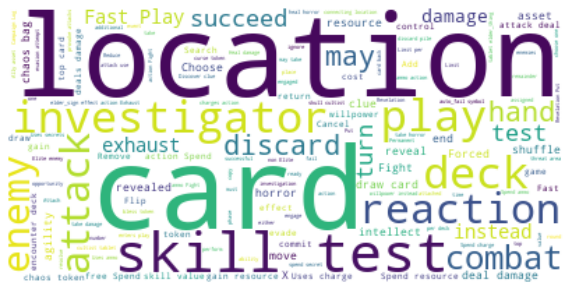

In [26]:
# join all card text
text = " ".join(text for text in df_card_text.clean_text)

# Create stopword list:
stopwords = set(STOPWORDS)

#stopwords.update(["good", "great", "coffee", "place", "really",
#                 "one", "shop", "time", "Austin", "love", "go",
#                 "nice","got","make","try","best","lot",
#                 "delicious","come","back"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords,
                      #max_font_size=50,
                     #max_words=100,
                     background_color="white").generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

(-0.5, 399.5, 199.5, -0.5)

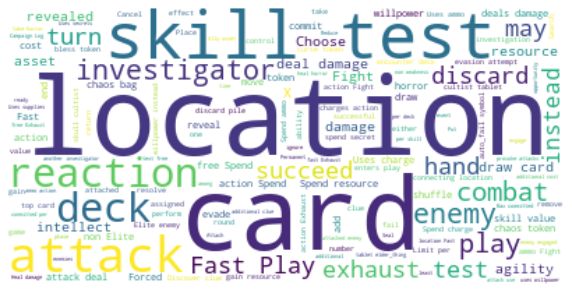

In [27]:
# join all player card text
text = " ".join(text for text in df_player_card_text.clean_text)

# Create stopword list:
stopwords = set(STOPWORDS)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords,
                      #max_font_size=50,
                     #max_words=100,
                     background_color="white").generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Get images for wordclouds

In [28]:
# Get images. Take average to convert to grayscale
rogue_mask = np.array(Image.open("images/rogue2.png"))
rogue_mask = np.mean(rogue_mask, axis=2)

mystic_mask = np.array(Image.open("images/mystic3.png"))
mystic_mask = np.mean(mystic_mask, axis=2)

guardian_mask = np.array(Image.open("images/guardian2.png"))
guardian_mask = np.mean(guardian_mask, axis=2)

survivor_mask = np.array(Image.open("images/survivor2.png"))
survivor_mask = np.mean(survivor_mask, axis=2)

seeker_mask = np.array(Image.open("images/seeker2.png"))
seeker_mask = np.mean(seeker_mask, axis=2)

#wine_mask = np.array(Image.open("wine.png"))

The way the masking functions works is that it requires all white part of the mask should be 255 not 0 (integer type). This value represents the "intensity" of the pixel. Values of 255 are pure white, whereas values of 1 are black. Here, you can use the provided function below to transform your mask if your mask has the same format as above. Notice if you have a mask that the background is not 0, but 1 or 2, adjust the function to match your mask. 
  
First, you use the transform_format() function to swap number 0 to 255.

In [29]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

Then, create a new mask with the same shape as the mask you have in hand and apply the function transform_format() to each value in each row of the previous mask.

In [30]:
# Transform your mask into a new one that will work with the function:
transformed_rogue_mask = np.ndarray((rogue_mask.shape[0],rogue_mask.shape[1]), np.int32)
transformed_mystic_mask = np.ndarray((mystic_mask.shape[0],mystic_mask.shape[1]), np.int32)
transformed_survivor_mask = np.ndarray((survivor_mask.shape[0],survivor_mask.shape[1]), np.int32)
transformed_guardian_mask = np.ndarray((guardian_mask.shape[0],guardian_mask.shape[1]), np.int32)
transformed_seeker_mask = np.ndarray((seeker_mask.shape[0],seeker_mask.shape[1]), np.int32)

for i in range(len(rogue_mask)):
    transformed_rogue_mask[i] = list(map(transform_format, rogue_mask[i]))

for i in range(len(mystic_mask)):
    transformed_mystic_mask[i] = list(map(transform_format, mystic_mask[i]))
 
for i in range(len(guardian_mask)):
    transformed_guardian_mask[i] = list(map(transform_format, guardian_mask[i]))

for i in range(len(survivor_mask)):
    transformed_survivor_mask[i] = list(map(transform_format, survivor_mask[i]))
    
for i in range(len(seeker_mask)):
    transformed_seeker_mask[i] = list(map(transform_format, seeker_mask[i]))

Pad the transformed masks with a border to avoid edges getting cut off

In [31]:
transformed_rogue_mask = np.pad(transformed_rogue_mask, 
                                   pad_width=10, mode='constant', constant_values=255)
transformed_mystic_mask = np.pad(transformed_mystic_mask, 
                                   pad_width=10, mode='constant', constant_values=255)
transformed_guardian_mask = np.pad(transformed_guardian_mask, 
                                   pad_width=10, mode='constant', constant_values=255)
transformed_survivor_mask = np.pad(transformed_survivor_mask, 
                                   pad_width=10, mode='constant', constant_values=255)
transformed_seeker_mask = np.pad(transformed_seeker_mask, 
                                   pad_width=10, mode='constant', constant_values=255)

#### All classes of player cards in 1 figure

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)

In [52]:
# Generate mask colors
mask_colors_r = ImageColorGenerator(np.array(Image.open("images/rogue2.png")))
mask_colors_m = ImageColorGenerator(np.array(Image.open("images/mystic3.png")))
mask_colors_g = ImageColorGenerator(np.array(Image.open("images/guardian.jpg")))
mask_colors_sk = ImageColorGenerator(np.array(Image.open("images/seeker.jpg")))
mask_colors_su = ImageColorGenerator(np.array(Image.open("images/survivor2.jpg")))

In [79]:
# Create and generate guardian word cloud image:
# join all card text
text = " ".join(text for text in df_card_text[df_card_text.faction_name == 'Guardian'].clean_text)

wordcloud_g = WordCloud(stopwords=stopwords,
                        background_color="white",
                        mask = transformed_guardian_mask,
                        contour_width=1,
                        contour_color = "blue",
                        color_func=mask_colors_g).generate(text)

# Create and generate mystic word cloud image:
# join all card text
text = " ".join(text for text in df_card_text[df_card_text.faction_name == 'Mystic'].clean_text)

wordcloud_m = WordCloud(stopwords=stopwords,
                        background_color="white",
                        mask = transformed_mystic_mask,
                        contour_width=1,
                        contour_color = "purple",
                        #color_func=mask_colors_m
                       ).generate(text)

# Create and generate rogue word cloud image:
# join all card text
text = " ".join(text for text in df_card_text[df_card_text.faction_name == 'Rogue'].clean_text)

wordcloud_r = WordCloud(stopwords=stopwords,
                        background_color="white",
                        mask = transformed_rogue_mask,
                        contour_width=1,
                        contour_color = "green",
                        color_func=mask_colors_r).generate(text)

# Create and generate seeker word cloud image:
# join all card text
text = " ".join(text for text in df_card_text[df_card_text.faction_name == 'Seeker'].clean_text)

wordcloud_sk = WordCloud(stopwords=stopwords,
                        background_color="white",
                        mask = transformed_seeker_mask,
                        contour_width=1,
                        contour_color = "gold",
                        color_func=mask_colors_sk).generate(text)

# Create and generate survivor word cloud image:
# join all card text
text = " ".join(text for text in df_card_text[df_card_text.faction_name == 'Survivor'].clean_text)

wordcloud_su = WordCloud(stopwords=stopwords,
                        #max_font_size=50, #max_words=100,
                        background_color="white",
                        #mask = transformed_survivor_mask,
                        contour_width=1,
                        contour_color = "red",
                        color_func=mask_colors_su).generate(text)

(-0.5, 225.5, 240.5, -0.5)

(-0.5, 243.5, 241.5, -0.5)

(-0.5, 308.5, 299.5, -0.5)

(-0.5, 229.5, 279.5, -0.5)

(-0.5, 399.5, 199.5, -0.5)

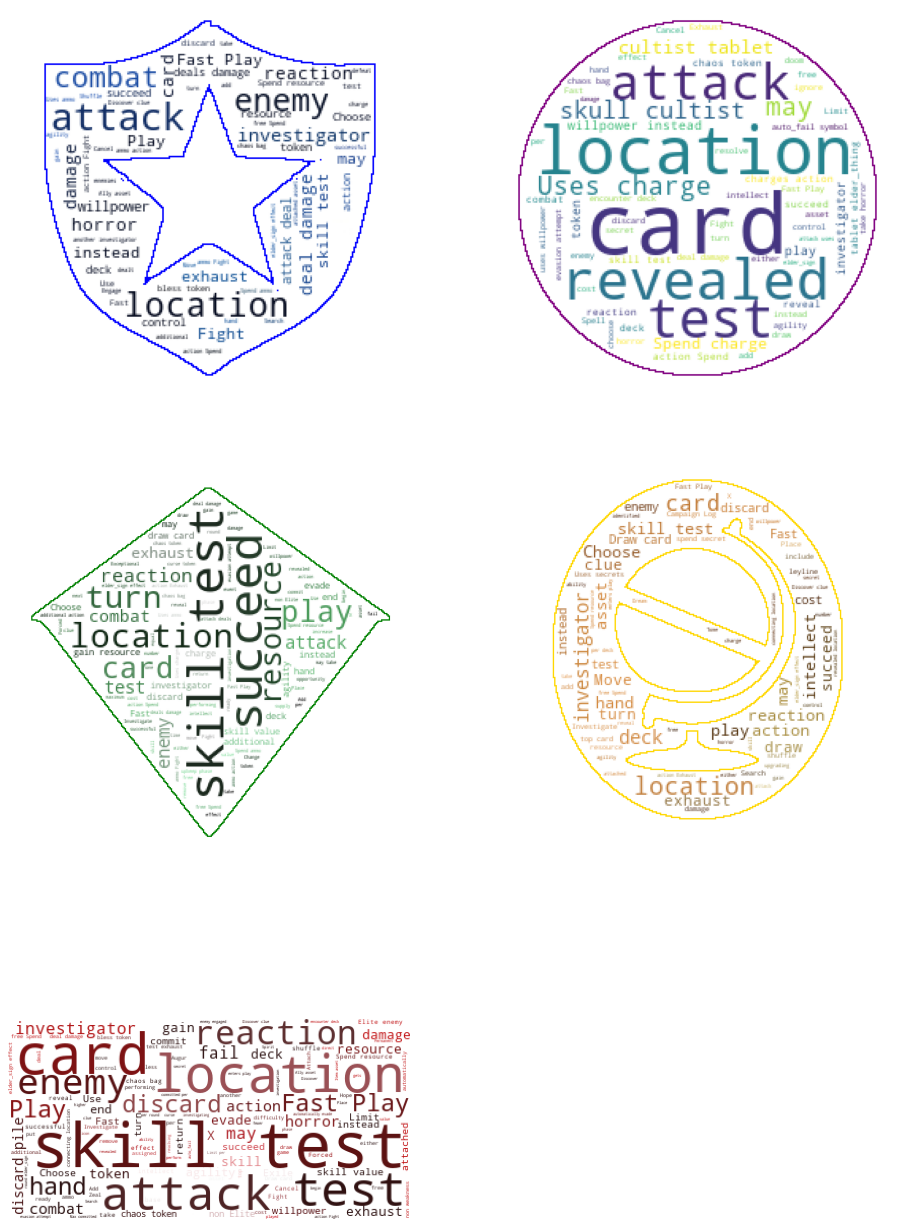

In [80]:
fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(16)

ax = fig.add_subplot(3,2,1)
ax.imshow(wordcloud_g)
ax.axis('off')

ax = fig.add_subplot(3,2,2)
ax.imshow(wordcloud_m)
ax.axis('off')

ax = fig.add_subplot(3,2,3)
ax.imshow(wordcloud_r)
ax.axis('off')

ax = fig.add_subplot(3,2,4)
ax.imshow(wordcloud_sk)
ax.axis('off')

ax = fig.add_subplot(3,2,5)
ax.imshow(wordcloud_su)
ax.axis('off')

<Figure size 576x432 with 0 Axes>

(-0.5, 279.5, 218.5, -0.5)

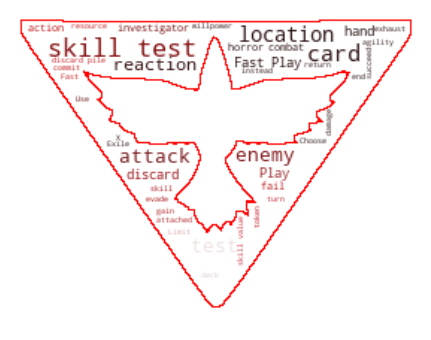

In [74]:
# Display the wordcloud:
plt.figure(figsize=(8,6))
plt.imshow(wordcloud_su, interpolation='bilinear')
plt.axis("off")
plt.show()